#### Time series domain/annual average TS
- calculate annual average BHISTsmbb  TS
- calculate annual average BSSP370smbb TS 
- calculate annual and global average TS
- plotting
  
Ming Ge July 2025

In [1]:
import numpy
import datetime
import os
import glob
from calendar import isleap
from tqdm import tqdm
from netCDF4 import Dataset
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
 

#### Historical

In [2]:
dir_lens2 = '/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/month_1/TS/'
dir_o = '/glade/campaign/mmm/c3we/mingge/LENS2/TS/'

year_s = 1850
year_e = 2014

year_s_1d = list(range(year_s, year_e, 10))
year_e_1d = list(range(year_s+9, year_e+9, 10))
year_e_1d[-1] = 2014

n_year = year_e - year_s + 1
n_mem = 10

for mm in range(1, n_mem+1):
    print(mm)
    for nn in range(len(year_s_1d)):
        n_period = (year_e_1d[nn] - year_s_1d[nn] + 1 )*12
        time_s = str(year_s_1d[nn]) + '01-' + str(year_e_1d[nn]) + '12'
        flnm = sorted (glob.glob(dir_lens2 + 
                             'b.e21.BHISTsmbb.f09_g17.LE2-' +
                             '*.' + str(mm).zfill(3) +
                             '.cam.h0.TS.'+time_s+'.nc'))[0]
        flnm_o = dir_o + flnm[len(dir_lens2):]
        #print((flnm_o))

        with xr.open_dataset(flnm, engine="netcdf4") as ds:
            sst_0 = ds.TS
            #sst = sst_0.where(sst_0 > 0)
            # reassign or replace the monthly time coordinate of an xarray 
            new_time = xr.cftime_range(start=str(year_s_1d[nn]) + '-01-01', periods=n_period, freq='MS') 
            sst = sst_0.assign_coords(time=new_time)
            
            # annual average
            sst_new = sst.resample(time='1Y').mean()
            
            # Reassign the coordinate
            years = np.arange(year_s_1d[nn], year_e_1d[nn]+1)
             
            sst_new = sst_new.assign_coords(time=years)
            sst_new.to_netcdf(flnm_o) 
 

1
2
3
4
5
6
7
8
9
10


#### Future senario

In [ ]:
year_s = 2015
year_e = 2100

year_s_1d = list(range(year_s, year_e, 10))
year_e_1d = list(range(year_s+9, year_e+9, 10))
year_e_1d[-1] = 2100

n_year = year_e - year_s + 1
n_mem = 10

for mm in range(1, n_mem+1):
    print(mm)
    
    for nn in range(len(year_s_1d)):
        n_period = (year_e_1d[nn] - year_s_1d[nn] + 1 )*12
        time_s = str(year_s_1d[nn]) + '01-' + str(year_e_1d[nn]) + '12'
        flnm = sorted (glob.glob(dir_lens2 + 
                             'b.e21.BSSP370smbb.f09_g17.LE2-' +
                             '*.' + str(mm).zfill(3) +
                             '.cam.h0.TS.'+time_s+'.nc'))[0]
        flnm_o = dir_o + flnm[len(dir_lens2):]
        print(flnm_o)
         
        with xr.open_dataset(flnm, engine="netcdf4") as ds:
            sst_0 = ds.TS
            #sst = sst_0.where(sst_0 > 0)
            # reassign or replace the monthly time coordinate of an xarray 
            new_time = xr.cftime_range(start=str(year_s_1d[nn]) + '-01-01', periods=n_period, freq='MS') 
            sst = sst_0.assign_coords(time=new_time)
            # annual average
            sst_new = sst.resample(time='1Y').mean()
            # Reassign the coordinate
            years = np.arange(year_s_1d[nn], year_e_1d[nn]+1)
             
            sst_new = sst_new.assign_coords(time=years)
            sst_new.to_netcdf(flnm_o) 

#### Calculate global annual average TS

In [4]:
year_s = 1850
year_e = 2100
n_year = year_e - year_s + 1
n_mem = 10

sst_2d = np.zeros((n_mem, n_year))

for mm in range(1, n_mem+1):
    n_s = 0
    flnms = sorted (glob.glob(dir_o + 
                             'b.e21.B*' + str(mm).zfill(3) +
                             '.cam.h0.TS.*.nc'))
    for nn in range(len(flnms)):
        with xr.open_dataset(flnms[nn], engine="netcdf4") as ds:
            sst =ds.TS.mean(dim=('lat', 'lon'))
            n_e = n_s + len(sst)
            #print(flnms[nn], n_s, n_e)
            sst_2d[mm-1, n_s:n_e] = sst 
        n_s = n_e

sst_da = xr.DataArray(
    sst_2d,
    coords={"member": range(1, n_mem+1), "year": range(year_s, year_e + 1)},
    dims=["member", "year"],
    name="TS"
)

# Save to NetCDF
flnm_ts_mean =  dir_o + "ts_GlobalAnnualMean.nc"
print('output file:', flnm_ts_mean)
sst_da.to_netcdf(flnm_ts_mean)

output file: /glade/campaign/mmm/c3we/mingge/LENS2/TS/ts_GlobalAnnualMean.nc


#### Plotting

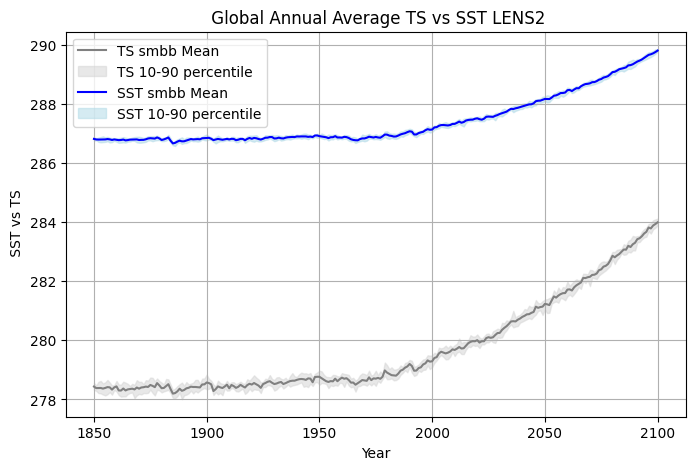

In [7]:
flnm_ts_mean  = "/glade/campaign/mmm/c3we/mingge/LENS2/TS/ts_GlobalAnnualMean.nc"
flnm_sst_mean = "/glade/campaign/mmm/c3we/mingge/LENS2/SST/sst_GlobalAnnualMean.nc"

with xr.open_dataset(flnm_ts_mean, engine="netcdf4") as ds_ts:
    ts_2d = ds_ts.TS
     
with xr.open_dataset(flnm_sst_mean, engine="netcdf4") as ds_sst:
    sst_2d = ds_sst.SST

# Average over the first dimension (axis=0)
ts_mean = np.mean(ts_2d, axis=(0))
sst_mean = np.mean(sst_2d, axis=(0))

# 10th and 90th percentiles over the first dimension
p10_ts = np.percentile(ts_2d, 10, axis=(0))
p90_ts = np.percentile(ts_2d, 90, axis=(0))
p10_sst = np.percentile(sst_2d, 10, axis=(0))
p90_sst = np.percentile(sst_2d, 90, axis=(0))


years = np.arange(year_s, year_e+1) 

#x = np.arange(cape_2d.shape[1])  # e.g. 0 to 49
plt.figure(figsize=(8,5))
plt.plot(years, ts_mean, label='TS smbb Mean', color='grey')
plt.fill_between(years, p10_ts, p90_ts, color='lightgrey', alpha=0.5, label='TS 10-90 percentile')

plt.plot(years, sst_mean, label='SST smbb Mean', color='blue')
plt.fill_between(years, p10_sst, p90_sst, color='lightblue', alpha=0.5, label='SST 10-90 percentile')


plt.xlabel('Year')
plt.ylabel(' SST vs TS')
plt.title(' Global Annual Average TS vs SST LENS2')
plt.legend()
plt.grid(True)
plt.show()